# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


First of all, you have you have to read the data. Run the cell below to unpack data.

In [ ]:
from get_data import unpack
unpack('Face_Recognition_data.zip')

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recognition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [3]:
import csv, os, random

In [5]:
def load_image_data(dir_name = './Face_Recognition_data/image_classification'):
    train_labels = {}
    train_images = {}
    with open(os.path.join(dir_name,"train/y_train.csv"), 'r') as csvfile:
        folder = "./train/images"
        csvreader = csv.reader(csvfile)
        count=0
        for row in csvreader:
            if count==0:
                count+=1
                continue
            filename = row[0]
            train_labels[filename] = row[1]
            train_images[filename] =  mpimg.imread(os.path.join(dir_name,folder,filename))
    
    test_labels = {}
    test_images = {}
    with open(os.path.join(dir_name,"test/y_test.csv"), 'r') as csvfile:
        folder = "./test/images"
        csvreader = csv.reader(csvfile)
        count=0
        for row in csvreader:
            if count==0:
                count+=1
                continue
            filename = row[0]
            test_labels[filename] = row[1]
            test_images[filename] =  mpimg.imread(os.path.join(dir_name,folder,filename))
            
    return train_images,train_labels,test_images,test_labels

In [6]:
x_train, y_train, x_test, y_test = load_image_data()
print('%d'%len(x_train), '\ttraining images')
print('%d'%len(x_test), '\ttesting images')

661 	training images
808 	testing images


In [7]:
print(x_train['3.jpg'].shape)
print(y_train['3.jpg'])

(240, 244, 3)
Laura_Bush


In [4]:
import random
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    arr = random.sample(data.keys(), n_cols*n_rows)
    for n,i in enumerate(arr):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

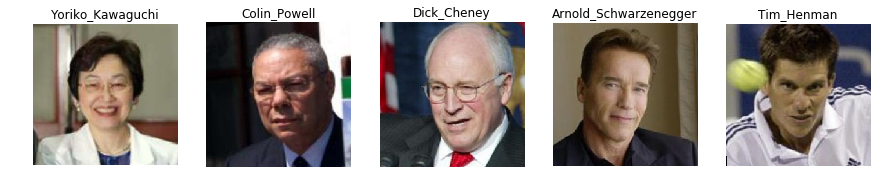

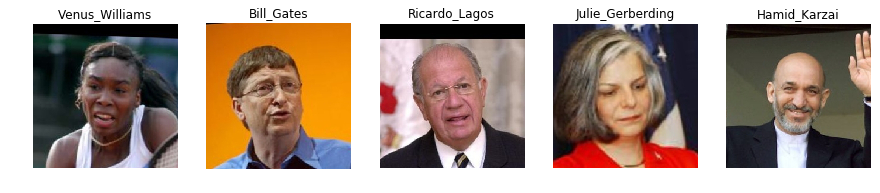

In [9]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [10]:
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    train_labels = {}
    train_images = {}
    with open(os.path.join(dir_name,"train/y_train.csv"), 'r') as csvfile:
        folder = "./train/images"
        csvreader = csv.reader(csvfile)
        count=0
        for row in csvreader:
            if count==0:
                count+=1
                continue
            filename = row[0]
            train_labels[filename] = row[1]
            train_images[filename] =  mpimg.imread(os.path.join(dir_name,folder,filename))
    
    test_labels = {}
    test_images = {}
    with open(os.path.join(dir_name,"test/y_test.csv"), 'r') as csvfile:
        folder = "test/videos"
        csvreader = csv.reader(csvfile)
        count=0
        for row in csvreader:
            count+=1
            if count==1:
                continue
            if count==11:
                break
            foldername = row[0]
            test_labels[foldername] = row[1]
            test_images[foldername] = []
            for filename in os.listdir(os.path.join(dir_name,folder,foldername)):
                test_images[foldername].append(mpimg.imread(os.path.join(dir_name,folder,foldername,filename)))
    
    return train_images,train_labels,test_images,test_labels

In [15]:
video_train, train_labels, video_test, test_labels = load_video_data()
print('%d'%len(video_train), '\ttraining images')
print('%d'%len(video_test), '\ttesting videos')

729 	training images
9 	testing videos


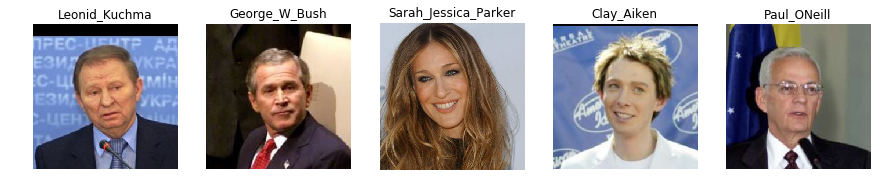

In [16]:
visualize(video_train, train_labels)

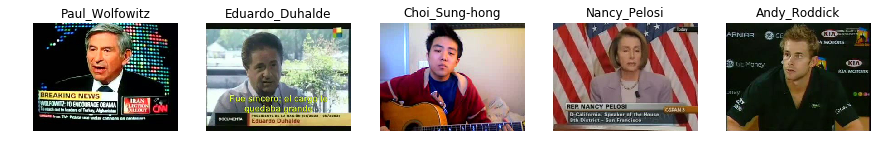

In [18]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

## From Face Detection Task

In [4]:
from get_data_week3 import load_dataset
train_images, train_bboxes, train_shapes = load_dataset("data", "train")

In [5]:
from scores import iou_score # https://en.wikipedia.org/wiki/Jaccard_index

SAMPLE_SHAPE = (32, 32, 3)


def is_negative_bbox(new_bbox, true_bboxes, eps=1e-1):
    """Check if new bbox not in true bbox list.
    
    There bbox is 4 ints [min_row, min_col, max_row, max_col] without image index."""
    for bbox in true_bboxes:
        if iou_score(new_bbox, bbox) >= eps:
            return False
    return True

def gen_negative_bbox(image_shape, bbox_size, true_bboxes):
    """Generate negative bbox for image."""
    try_count=1000
    for i in range(try_count):
        corner_x = np.random.randint(max(image_shape[0]-bbox_size,1))
        corner_y = np.random.randint(max(image_shape[1]-bbox_size,1))
        new_bbox = [corner_x, corner_y, corner_x + bbox_size, corner_y + bbox_size]

        if is_negative_bbox(new_bbox,true_bboxes):
            return new_bbox
    return None

def crop(true_bbox):
    x_dim = true_bbox[2]-true_bbox[0]
    y_dim = true_bbox[3]-true_bbox[1]
    cropped = np.copy(true_bbox)
    if x_dim==y_dim:
        return true_bbox
    if x_dim>y_dim:
        diff = x_dim-y_dim
        cropped[1] = max(true_bbox[1] - diff,0)
        cropped[3] = cropped[1] + x_dim
    else:
        diff = y_dim-x_dim
        cropped[0] = max(true_bbox[0] - diff,0)
        cropped[2] = cropped[2] + y_dim
    return cropped

        
def get_positive_negative(images, true_bboxes, image_shapes, negative_bbox_count=None):
    """Retrieve positive and negative samples from image."""
    positive = []
    negative = []
    image_count = image_shapes.shape[0]
    side = SAMPLE_SHAPE[0]
    
    if negative_bbox_count is None:
        negative_bbox_count = len(true_bboxes)

    for i in range(negative_bbox_count):
        image_index = np.random.randint(image_count)
        image_shape = image_shapes[image_index]
        image_true_bboxes = true_bboxes[true_bboxes[:, 0] == image_index, 1:]
        bbox_size = np.random.randint(25,50)
        
        if image_shape[0]<bbox_size or image_shape[1]<bbox_size:
            bbox_size = min(image_shape[0],min(image_shape[1],32))
        
        neg_bbox = gen_negative_bbox(image_shape,bbox_size,image_true_bboxes)
        if neg_bbox is not None:
            negative.append(resize(images[image_index][neg_bbox[0]:neg_bbox[2],neg_bbox[1]:neg_bbox[3]],
                                                                                     (side,side,3)))
        
        pos_bbox = crop(true_bboxes[i][1:])
        positive.append(resize(images[true_bboxes[i][0]][pos_bbox[0]:pos_bbox[2],pos_bbox[1]:pos_bbox[3]],(side,side,3)))
   
    return positive, negative

In [6]:
def get_samples(images, true_bboxes, image_shapes):
    """Useful samples for learning.
    
    X - positive and negative samples.
    Y - one hot encoded list of zeros and ones. One is positive marker.
    """
    positive, negative = get_positive_negative(images=images, true_bboxes=true_bboxes, 
                                               image_shapes=image_shapes)
    X = positive
    Y = [[0, 1]] * len(positive)
    
    X.extend(negative)
    Y.extend([[1, 0]] * len(negative))
    
    return np.array(X), np.array(Y)

In [7]:
X_train, Y_train = get_samples(train_images, train_bboxes, train_shapes)

In [8]:
print(X_train.shape)

(1901, 32, 32, 3)


In [9]:
from keras.preprocessing.image import ImageDataGenerator # Useful thing. Read the doc.

datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.1,
                             samplewise_center = True,
                             samplewise_std_normalization = True
                            )
datagen.fit(X_train)

In [10]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation, Input, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

def generate_model(sample_shape):
    # Classification model
    # You can start from LeNet architecture
    x = inputs = Input(shape=sample_shape)
    
    conv1 = Conv2D(20, kernel_size=(3,3), activation='relu',padding='same')(x)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    conv2 = Conv2D(40, kernel_size=(3,3), activation='relu',padding='same')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
    flat = Flatten()(pool2)
    hidden1 = Dense(64, activation='relu')(flat)
    dropout1 = Dropout(0.5)(hidden1)
    hidden2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(hidden2)
    
    # This creates a model
    predictions = Dense(2, activation='softmax')(dropout2)
    return Model(inputs=x, outputs=predictions)

cnn_model = generate_model(SAMPLE_SHAPE)

In [11]:
# FCNN

IMAGE_SHAPE = (176, 176, 3)

def generate_fcnn_model(image_shape):
    """After model compilation input size cannot be changed.
    
    So, we need create a function to have ability to change size later.
    """
    x = inputs = Input(image_shape)

    conv1 = Conv2D(20, kernel_size=(3,3), activation='relu',padding='same')(x)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    conv2 = Conv2D(40, kernel_size=(3,3), activation='relu',padding='same')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
    
    conv3 = Conv2D(64, kernel_size=(8,8),activation='relu')(pool2)
    dropout1 = Dropout(0.5)(conv3)
    conv4 = Conv2D(32, kernel_size=(1,1),activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(conv4)

    # This creates a model
    predictions = Conv2D(2, (1, 1), activation='linear')(dropout2)
    return Model(inputs=inputs, outputs=predictions)

fcnn_model = generate_fcnn_model(IMAGE_SHAPE)

In [12]:
def get_checkpoint():
    return "/home/goutham/Desktop/Assignments and Projects/Coursera/Deep Learning in Computer Vision/Assignment - Week 3/data/checkpoints/my_face_model-50.hdf5"

cnn_model.load_weights(get_checkpoint())

def copy_weights(base_model, fcnn_model):
    """Set FCNN weights from base model.
    """
    
    new_fcnn_weights = []
    prev_fcnn_weights = fcnn_model.get_weights()
    prev_base_weights = base_model.get_weights()
            
    for i in range(len(prev_fcnn_weights)):    
        new_fcnn_weights.append(prev_base_weights[i].reshape(prev_fcnn_weights[i].shape))
        
    fcnn_model.set_weights(new_fcnn_weights)

copy_weights(base_model=cnn_model, fcnn_model=fcnn_model)

In [13]:
del X_train, Y_train, train_images, train_bboxes, train_shapes

In [14]:
from graph import visualize_heatmap
from skimage.transform import resize
from skimage.feature import peak_local_max
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

## Facial keypoints model

In [15]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    plt.figure()
    plt.imshow(img)
    cols,rows,_ = img.shape
    patches=[]
    r=0.4
    fig = plt.gcf()
    ax = fig.gca()
    for i in range(14):
        ax.add_artist((Circle(((points[2*i]+0.5)*cols, (points[2*i+1]+0.5)*rows), r, color='r')))
        
def visualize_points1(img, points,j):
    plt.figure()
    plt.imshow(img)
    cols,rows,_ = img.shape
    patches=[]
    r=0.4
    fig = plt.gcf()
    ax = fig.gca()
    for i in range(j,j+1):
        ax.add_artist((Circle(((points[2*i]+0.5)*cols, (points[2*i+1]+0.5)*rows), r, color='r')))

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import glorot_uniform

img_size = 50

key_model = Sequential()

key_model.add(Conv2D(16, (3,3), input_shape=(img_size, img_size, 3), padding="same",kernel_initializer=glorot_uniform()))
key_model.add(LeakyReLU(alpha=0.1))
key_model.add(MaxPooling2D(pool_size=(2, 2)))
key_model.add(Dropout(0.25))

key_model.add(Conv2D(32, (3,3), padding="same",kernel_initializer=glorot_uniform()))
key_model.add(LeakyReLU(alpha=0.1))
key_model.add(MaxPooling2D(pool_size=(2, 2)))
key_model.add(Dropout(0.25))

key_model.add(Conv2D(64, (3,3), padding="same",kernel_initializer=glorot_uniform()))
key_model.add(LeakyReLU(alpha=0.1))
key_model.add(MaxPooling2D(pool_size=(2, 2)))
key_model.add(Dropout(0.25))  

key_model.add(Flatten())
key_model.add(Dense(128,kernel_initializer=glorot_uniform()))
key_model.add(LeakyReLU(alpha=0.1))

key_model.add(Dropout(0.5)) 

key_model.add(Dense(64,kernel_initializer=glorot_uniform()))
key_model.add(LeakyReLU(alpha=0))

key_model.add(Dense(28,kernel_initializer=glorot_uniform()))


key_model.load_weights('my_model_weights.h5')

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [17]:
def preprocess_imgs(imgs):
    
    # Resize images to input into face detector from week 3
    imgs = [resize(img,(176,176)) for img in imgs]
    
    # fcnn face detector
    predictions = fcnn_model.predict(np.array(datagen.standardize(imgs)))
#     visualize_heatmap(imgs, predictions[:,:,:,1])
    
    processed_imgs = []
    
    for i in range(len(predictions)):
        size = 150
        m_x,m_y = peak_local_max(predictions[i][:,:,1], num_peaks=1, min_distance=3, exclude_border=True)[0]
        
        top_left_list = []
        max_avg = None
        argmax = -1
        
        # checking which crop is best based on highest mean predicted values
        factors = [0.05,0.1,0.15,0.25,0.33,0.5,2,3,4,8,10,15,20]
        for k,j in enumerate(factors):
            top_left=[m_x-size//j,m_y-size//j]
            if top_left[0]<0:
                top_left[0]=0
            if top_left[1]<0:
                top_left[1]=0
            top_left_list.append(top_left)
            
            avg = np.mean(predictions[i][top_left[0]:top_left[0]+size,top_left[1]:top_left[1]+size,1])
            if max_avg is None or avg>max_avg:
                avg = max_avg
                argmax = k
        
        top_left = top_left_list[argmax]
#         print(m_x,m_y,argmax,top_left,factors[argmax])
        face_detec_img = imgs[i][top_left[0]:top_left[0]+size,top_left[1]:top_left[1]+size]
#         imshow(face_detec_img)

        # Resize images to input into keypoints detector from week 2
        face_detec_img_res = resize(face_detec_img,(50,50))
#         print(face_detec_img.shape)

        #facial keypoints prediction
        points_pred = key_model.predict(np.reshape(face_detec_img_res,(1,50,50,3)))[0]
#         visualize_points(face_detec_img, points_pred)
        
        points_pred = points_pred+0.5
        shap = face_detec_img.shape
        x_max = shap[0]
        y_max = shap[1]
        left = [int(points_pred[0]*x_max), int(points_pred[1]*y_max)]
        right = [int(points_pred[6]*x_max), int(points_pred[7]*y_max)]
        diff_x = right[0]-left[0]
        
        t_l = [0,0]
        t_l[0] = min(max(0,left[0]-diff_x//2),x_max)
        t_l[1] = min(max(0,left[1]-diff_x//5),y_max)
        b_r = [0,0]
        b_r[0] = min(max(0,left[0]+3*diff_x//2),x_max)
        b_r[1] = min(max(0,left[1]+9*diff_x//5),y_max)
        
        if b_r[0]-t_l[0]!=b_r[1]-t_l[1]:
            t_l[1] = b_r[1] + t_l[0] - b_r[0] 
        
#         print(left,right,diff_x,t_l,b_r,shap)
        processed_img = face_detec_img[t_l[0]:b_r[0],t_l[1]:b_r[1]]
#         print(processed_img.shape)
        
        processed_imgs.append(resize(processed_img,(224,224,3)))
        
#         plt.figure()
#         imshow(processed_imgs[i])
    
        
    return np.array(processed_imgs)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(19, 224, 224, 3)


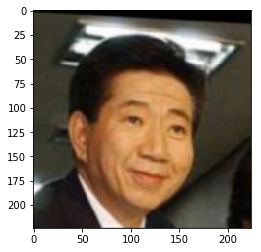

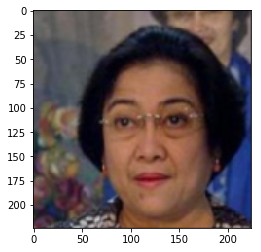

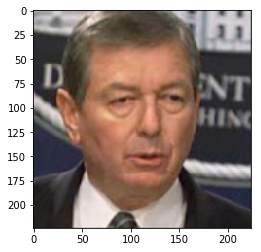

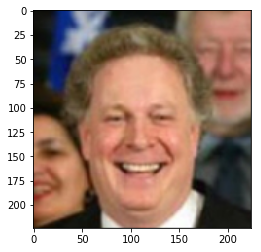

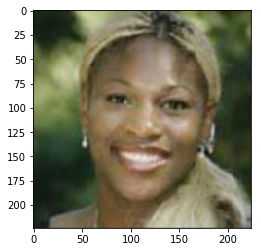

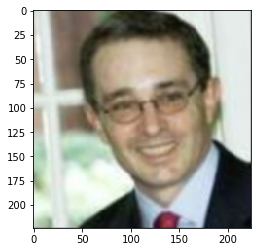

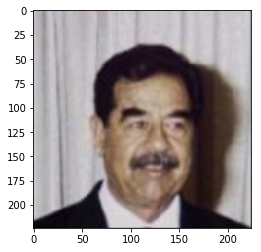

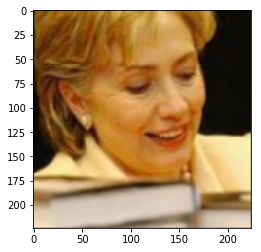

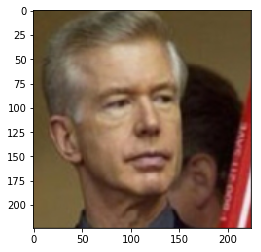

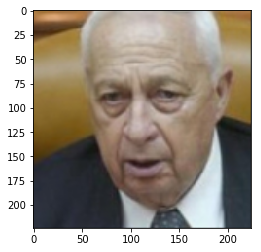

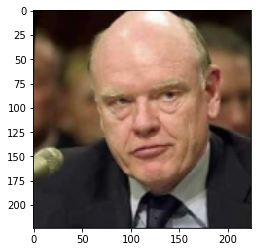

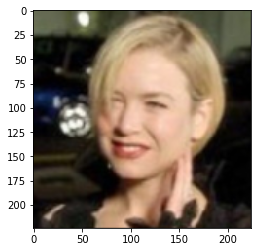

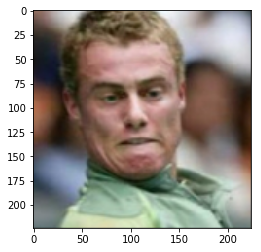

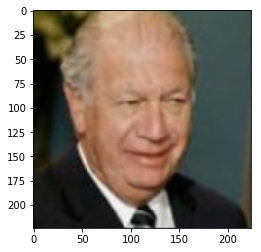

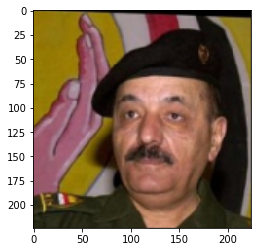

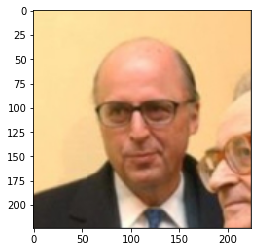

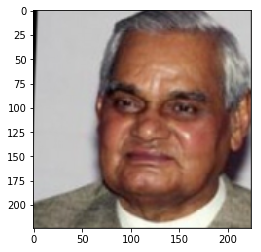

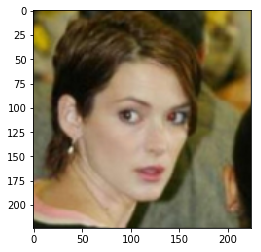

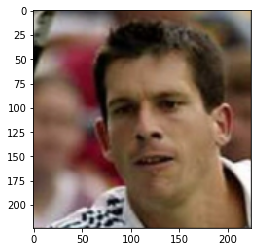

In [45]:
tmp = [x_train[key] for key in x_train.keys()]
tmp_keys = [key for key in x_train.keys()]
processed_imgs = preprocess_imgs(tmp[1:20])
print(processed_imgs.shape)

In [60]:
tmp = [x_train[key] for key in x_train.keys()]
tmp_keys = [key for key in x_train.keys()]
processed_imgs = preprocess_imgs(tmp)
print(len(processed_imgs))
direc = "./Face_Recognition_data/image_classification/train/processed/"
for i,processed_img in enumerate(processed_imgs):
    matplotlib.pyplot.imsave(direc+tmp_keys[i], processed_img)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


661


In [62]:
tmp = [x_test[key] for key in x_test.keys()]
tmp_keys = [key for key in x_test.keys()]
processed_imgs = preprocess_imgs(tmp)
print(len(processed_imgs))
direc = "./Face_Recognition_data/image_classification/test/processed/"
for i,processed_img in enumerate(processed_imgs):
    matplotlib.pyplot.imsave(direc+tmp_keys[i], processed_img)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


808


#### Visualization of preprocessing

In [263]:
print(x_train['0.jpg'].shape)

(242, 242, 3)


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


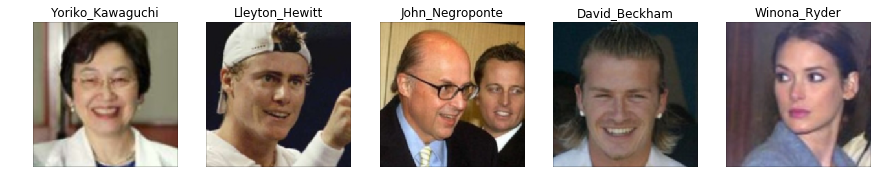

In [284]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

# Decent face isolation is achieved after preprocessing as seen above!
The processed images have been stored for easy use. My laptop has very limited RAM and processing power. Therefore I have processed the images, run them through the network and saved the features as numpy arrays on disk, which I read later during training of the model. 

In [24]:
import csv,os

def load_image_data_processed(dir_name = './Face_Recognition_data/image_classification'):
    train_labels = {}
    train_images = {}
    with open(os.path.join(dir_name,"train/y_train.csv"), 'r') as csvfile:
        folder = "train/processed/"
        features_folder = "train/features_fc7"
        csvreader = csv.reader(csvfile)
        count=0
        for row in csvreader:
            if count==0:
                count+=1
                continue
            filename = row[0]
            train_labels[filename] = row[1]
            img = mpimg.imread(os.path.join(dir_name,folder,filename))
#             train_images[filename] = img
            np.save(os.path.join(dir_name,features_folder,filename[:-4])+".npy", 
                    get_layer_output(model,img.reshape((1,224,224,3)),'fc7'))
    
    test_labels = {}
    test_images = {}
    with open(os.path.join(dir_name,"test/y_test.csv"), 'r') as csvfile:
        folder = "test/processed"
        features_folder = "test/features_fc7"
        csvreader = csv.reader(csvfile)
        count=0
        for row in csvreader:
            if count==0:
                count+=1
                continue
            filename = row[0]
            test_labels[filename] = row[1]
            img = mpimg.imread(os.path.join(dir_name,folder,filename))
#             test_images[filename] =  img
            np.save(os.path.join(dir_name,features_folder,filename[:-4])+".npy", 
                    get_layer_output(model,img.reshape((1,224,224,3)),'fc7'))
            
            
    return train_images,train_labels,test_images,test_labels

In [18]:
import csv, os

def load_video_data_processed(dir_name = 'Face_Recognition_data/video_classification'):
    
    train_labels = {}
    train_images = {}
    '''
    with open(os.path.join(dir_name,"train/y_train.csv"), 'r') as csvfile:
        folder = "train/images"
        processed_folder = "train/processed"
        features_folder = "train/features_fc7"
        csvreader = csv.reader(csvfile)
        count=0
        for row in csvreader:
            if count==0:
                count+=1
                continue
            filename = row[0]
            train_labels[filename] = row[1]
            img =  mpimg.imread(os.path.join(dir_name,folder,filename))
            processed_img = preprocess_imgs([img])[0]
#             matplotlib.pyplot.imsave(os.path.join(dir_name,processed_folder,filename), processed_img)
            np.save(os.path.join(dir_name,features_folder,filename[:-4])+".npy", 
                    get_layer_output(model,processed_img.reshape((1,224,224,3)),'fc7'))
    '''
    
    test_labels = {}
    test_images = {}
    with open(os.path.join(dir_name,"test/y_test.csv"), 'r') as csvfile:
        folder = "test/videos"
        features_folder = "test/features_fc7"
        csvreader = csv.reader(csvfile)
        count=0
        for row in csvreader:
            count+=1
            if count==1:
                continue
            foldername = row[0]
            test_labels[foldername] = row[1]
            if foldername in ['7','8','9']:
                for filename in os.listdir(os.path.join(dir_name,folder,foldername)):
                    img = mpimg.imread(os.path.join(dir_name,folder,foldername,filename))
                    processed_img = preprocess_imgs([img])[0]    
                    output_direc = os.path.join(dir_name,features_folder,foldername)
                    if not os.path.exists(output_direc):
                        os.makedirs(output_direc)
                    np.save(os.path.join(dir_name,features_folder,foldername,filename[:-4])+".npy", 
                        get_layer_output(model,processed_img.reshape(1,224,224,3),'fc7'))
    
    return train_images,train_labels,test_images,test_labels

In [21]:
x_train_processed_v, y_train_processed_v, x_test_processed_v, y_test_processed_v = load_video_data_processed()

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [27]:
arr0 = np.load("./Face_Recognition_data/image_classification/train/features/0.npy")
arr1 = np.load("./Face_Recognition_data/image_classification/train/features/10.npy")
print(arr.shape,arr1.shape)
print(np.sum(arr0-arr1))

(1, 4096) (1, 4096)
25224.371


In [27]:
x_train_processed, y_train_processed, x_test_processed, y_test_processed = load_image_data_processed()

661 808


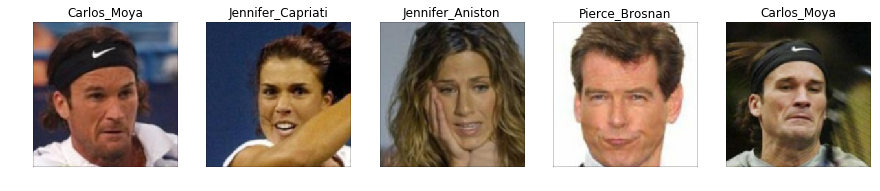

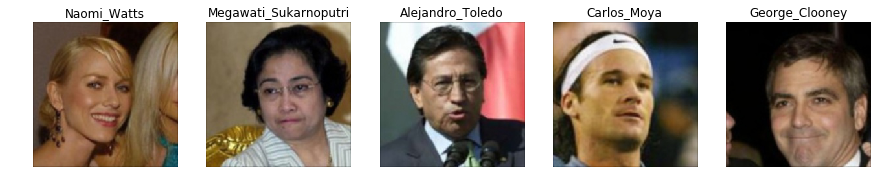

In [31]:
print(len(x_train_processed),len(x_test_processed))
visualize(x_train_processed, y_train_processed)
visualize(x_test_processed, y_test_processed)

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [19]:
import h5py
from keras.models import load_model
model = load_model('face_recognition_model.h5')

In [28]:
del model

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [20]:
def get_layer_output(model,images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [36]:
img = cv2.resize(x_train_processed['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(model,img)
print(out.shape)

(1, 4096)


### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [3]:
import numpy as np, csv

# Importing features of image classification data from disk

In [30]:
train_features = np.zeros((661,4096))
test_features = np.zeros((808,4096))
for i in range(661):
    train_features[i] = np.load("./Face_Recognition_data/image_classification/train/features_fc7/%d.npy"%i)
#     train_features[i] = np.load("./Face_Recognition_data/image_classification/train/features/%d.npy"%i)
    
for i in range(250,1058):
#     test_features[i-250] = np.load("./Face_Recognition_data/image_classification/test/features/%d.npy"%i)
    test_features[i-250] = np.load("./Face_Recognition_data/image_classification/test/features_fc7/%d.npy"%i)    

In [31]:
with open("./Face_Recognition_data/image_classification/train/y_train.csv", 'r') as csvfile:
    train_labels_dict={}
    folder = "train/processed/"
    csvreader = csv.reader(csvfile)
    count=0
    for row in csvreader:
        if count==0:
            count+=1
            continue
        filename = row[0]
        train_labels_dict[filename] = row[1]
file = "%d.jpg"
train_labels = [train_labels_dict[file%i] for i in range(661)]
train_files = [file%i for i in range(661)]

In [32]:
with open("./Face_Recognition_data/image_classification/test/y_test.csv", 'r') as csvfile:
    test_labels_dict={}
    folder = "test/processed/"
    csvreader = csv.reader(csvfile)
    count=0
    for row in csvreader:
        if count==0:
            count+=1
            continue
        filename = row[0]
        test_labels_dict[filename] = row[1]
file = "%d.jpg"
test_labels = [test_labels_dict[file%i] for i in range(250,1058)]
test_files = [file%i for i in range(250,1058)]

In [33]:
print(train_labels[0])
print(test_labels[0])

James_Blake
Pervez_Musharraf


# Importing features of video classification data from disk

In [2]:
import os, csv, numpy as np

In [3]:
train_features_v = np.zeros((729,4096))
for i in range(729):
    train_features_v[i] = np.load("./Face_Recognition_data/video_classification/train/features_fc7/%d.npy"%i)

In [4]:
dir_name = "./Face_Recognition_data/video_classification/test/features_fc7"
test_features_v=[]
for foldername in range(70):
    files = os.listdir(os.path.join(dir_name,str(foldername)))
    tmp = np.zeros((len(files),4096))
    for i in range(len(files)):
        tmp[i] = np.load(os.path.join(dir_name,str(foldername),"%d.npy"%i))
    test_features_v.append(tmp)
    print(foldername,tmp.shape)

0 (125, 4096)
1 (125, 4096)
2 (125, 4096)
3 (125, 4096)
4 (125, 4096)
5 (125, 4096)
6 (125, 4096)
7 (125, 4096)
8 (125, 4096)
9 (125, 4096)
10 (125, 4096)
11 (125, 4096)
12 (125, 4096)
13 (125, 4096)
14 (125, 4096)
15 (125, 4096)
16 (125, 4096)
17 (121, 4096)
18 (125, 4096)
19 (125, 4096)
20 (121, 4096)
21 (125, 4096)
22 (125, 4096)
23 (125, 4096)
24 (125, 4096)
25 (125, 4096)
26 (125, 4096)
27 (125, 4096)
28 (125, 4096)
29 (123, 4096)
30 (125, 4096)
31 (125, 4096)
32 (125, 4096)
33 (117, 4096)
34 (125, 4096)
35 (125, 4096)
36 (125, 4096)
37 (125, 4096)
38 (125, 4096)
39 (125, 4096)
40 (125, 4096)
41 (125, 4096)
42 (125, 4096)
43 (125, 4096)
44 (119, 4096)
45 (117, 4096)
46 (125, 4096)
47 (125, 4096)
48 (125, 4096)
49 (125, 4096)
50 (125, 4096)
51 (125, 4096)
52 (125, 4096)
53 (125, 4096)
54 (125, 4096)
55 (125, 4096)
56 (125, 4096)
57 (125, 4096)
58 (125, 4096)
59 (125, 4096)
60 (125, 4096)
61 (125, 4096)
62 (115, 4096)
63 (125, 4096)
64 (125, 4096)
65 (125, 4096)
66 (125, 4096)
67 (1

In [5]:
with open("./Face_Recognition_data/video_classification/train/y_train.csv", 'r') as csvfile:
    train_labels_v_dict={}
    folder = "train/processed/"
    csvreader = csv.reader(csvfile)
    count=0
    for row in csvreader:
        if count==0:
            count+=1
            continue
        filename = row[0]
        train_labels_v_dict[filename] = row[1]
file = "%d.jpg"
train_labels_v = [train_labels_v_dict[file%i] for i in range(729)]
train_v_files = [file%i for i in range(729)]

In [6]:
print(train_labels_v)

['Gene_Robinson', 'Geoff_Hoon', 'Laura_Bush', 'Martin_McGuinness', 'Edward_Lu', 'Tom_Cruise', 'Paul_ONeill', 'Nancy_Pelosi', 'Jan_Ullrich', 'Leonardo_DiCaprio', 'Cameron_Diaz', 'Yoko_Ono', 'Clay_Aiken', 'Leonid_Kuchma', 'Edward_Lu', 'Gene_Robinson', 'Edward_Lu', 'Fernando_Henrique_Cardoso', 'Allyson_Felix', 'Emma_Watson', 'Alejandro_Toledo', 'Nick_Nolte', 'Geoff_Hoon', 'Jake_Gyllenhaal', 'Salma_Hayek', 'Pete_Sampras', 'Martin_McGuinness', 'Lucy_Liu', 'Elizabeth_Hurley', 'Rick_Perry', 'Alvaro_Uribe', 'Vladimir_Putin', 'Hugh_Grant', 'Yoriko_Kawaguchi', 'Cameron_Diaz', 'Paul_Wolfowitz', 'Luiz_Inacio_Lula_da_Silva', 'Sarah_Hughes', 'Maria_Shriver', 'Luiz_Inacio_Lula_da_Silva', 'Salma_Hayek', 'Angela_Bassett', 'Colin_Montgomerie', 'Carrie-Anne_Moss', 'James_Wolfensohn', 'Saddam_Hussein', 'Kevin_Spacey', 'Kofi_Annan', 'Laura_Bush', 'Edward_Lu', 'Emma_Watson', 'Laura_Bush', 'Vladimir_Putin', 'Allyson_Felix', 'William_Ford_Jr', 'Condoleezza_Rice', 'Tim_Robbins', 'Tom_Hanks', 'Angela_Bassett', 

In [7]:
with open("./Face_Recognition_data/video_classification/test/y_test.csv", 'r') as csvfile:
    test_labels_v_dict={}
    folder = "test/processed/"
    csvreader = csv.reader(csvfile)
    count=0
    for row in csvreader:
        if count==0:
            count+=1
            continue
        filename = row[0]
        test_labels_v_dict[filename] = row[1]
file = "%d"
test_labels_v = [test_labels_v_dict[file%i] for i in range(70)]

In [9]:
print(test_labels_v)

['Nancy_Pelosi', 'Paul_Wolfowitz', 'Paul_ONeill', 'Ray_Romano', 'Angela_Bassett', 'Tom_Cruise', 'Gene_Robinson', 'Mahmoud_Abbas', 'Rick_Perry', 'Charlton_Heston', 'Andy_Roddick', 'Benazir_Bhutto', 'Eduardo_Duhalde', 'Leonid_Kuchma', 'Choi_Sung-hong', 'Kofi_Annan', 'Colin_Montgomerie', 'Bill_Clinton', 'Vladimir_Putin', 'Tom_Hanks', 'William_Donaldson', 'William_Ford_Jr', 'Mahathir_Mohamad', 'Elsa_Zylberstein', 'George_W_Bush', 'Laura_Bush', 'Valery_Giscard_dEstaing', 'Benjamin_Netanyahu', 'Abdullah_Gul', 'Bill_Frist', 'Mahmoud_Abbas', 'Mahathir_Mohamad', 'James_Wolfensohn', 'Jake_Gyllenhaal', 'Cameron_Diaz', 'Carrie-Anne_Moss', 'Tom_Hanks', 'Pedro_Malan', 'Allyson_Felix', 'Angela_Bassett', 'Thabo_Mbeki', 'Kevin_Spacey', 'Salma_Hayek', 'Carrie-Anne_Moss', 'Alejandro_Toledo', 'Jan_Ullrich', 'Carla_Del_Ponte', 'Ludivine_Sagnier', 'Zhu_Rongji', 'Christine_Todd_Whitman', 'Chanda_Rubin', 'Nicanor_Duarte_Frutos', 'Kofi_Annan', 'Nestor_Kirchner', 'Maria_Soledad_Alvear_Valenzuela', 'Paul_Bremer'

In [10]:
import pickle
from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import cv2
from os.path import join

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [69]:
class Classifier():
    def __init__(self, model_no):
        models = [SVC(),LogisticRegression(),GaussianNB(),RandomForestClassifier(),kNN(n_neighbors=15)]
        self.model_no = model_no
        self.model = models[model_no]
        
        self.label_enc = LabelEncoder()
        self.scaler = StandardScaler()
    
    def load_model(self,filename=None):
        if filename is None:
            filename = 'finalized_model_v-%d.sav'%self.model_no
        if os.path.exists(filename):
            self.model,self.label_enc,self.scaler = pickle.load(open(filename, 'rb'))
            return True
        else:
            return False
    
    def fit(self, train_imgs_features, train_labels, l=None, filename=None):
        
        t_features = self.scaler.fit_transform(np.array(train_imgs_features))
        t_labels = self.label_enc.fit_transform(train_labels)
        self.model.fit(t_features, np.array(t_labels))
        
        # save the model to disk
        if filename is None:
            filename = 'finalized_model_v-%d.sav'%self.model_no
        pickle.dump((self.model,self.label_enc,self.scaler), open(filename, 'wb'))

    def classify_images(self, test_imgs_features, test_files, l=None):
        
        output = self.label_enc.inverse_transform(self.model.predict(
            self.scaler.transform(np.array(test_imgs_features))))
                
        return {test_files[i]:output[i] for i in range(len(test_files))}
       
        
    def classify_videos(self, test_video):
        # test_video is a list of numpy arrays, each corresponding to one folder/video
        op = {}
        for i in range(len(test_video)):
            preds = self.model.predict(self.scaler.transform(test_video[i]))
#             print(i,test_video[i].shape,preds.shape)
            
#             preds_proba = self.model.predict_proba(self.scaler.transform(test_video[i]))
#             n = np.argmax(np.sum(preds_proba,axis=0))
#             print(preds_proba.shape,n)
            
            (values,counts) = np.unique(preds,return_counts=True)
            ind=np.argmax(counts)
            n = values[ind]
#             print(values,counts,ind,values[ind])

            lab = self.label_enc.inverse_transform(n)
            op[str(i)] = lab
#             print(i,lab)
        return op

Now we can build the classifier, fit it and use to predict the labels of testing images.

# Testing on videos

In [82]:
img_classifier_v = Classifier(1)

In [83]:
img_classifier_v.load_model()

True

In [51]:
num=None
img_classifier_v.fit(train_features_v, train_labels_v, num)

In [59]:
y_out_v_tr = img_classifier_v.classify_images(train_features_v,train_v_files)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [60]:
print(check_test(y_out_v_tr, train_labels_v_dict))

Classification accuracy is 1.0000


In [85]:
y_out_v = img_classifier_v.classify_videos(test_features_v)

In [50]:
print(test_labels_v_dict['1'])

Paul_Wolfowitz


In [62]:
print(check_test(y_out_v, test_labels_v_dict))

Classification accuracy is 0.1429


In [72]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [66]:
import time

In [75]:
for i in range(0,5):
    tic = time.time()
    img_classifier_v = Classifier(i)
    num=None
    if not img_classifier_v.load_model():
        img_classifier_v.fit(train_features_v, train_labels_v, num)
    y_out_v = img_classifier_v.classify_videos(test_features_v) 
    print(i)
    print(check_test(y_out_v, test_labels_v_dict),round(time.time()-tic))    

0
Classification accuracy is 0.0857 93
1
Classification accuracy is 0.1429 2
2
Classification accuracy is 0.0714 63
3
Classification accuracy is 0.0571 1
4
Classification accuracy is 0.0714 123


# Testing on images

In [18]:
img_classifier = Classifier(0)

In [56]:
img_classifier.load_model()

In [45]:
num=None
img_classifier.fit(train_features, train_labels, num)

In [57]:
num=None
y_out = img_classifier.classify_images(test_features, test_files, num)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [58]:
print(check_test(y_out, test_labels_dict))

Classification accuracy is 0.9740


In [37]:
import time

In [53]:
for i in range(0,5):
    print(i)
    tic = time.time()
    img_classifier = Classifier(i)
    num=None
    img_classifier.fit(train_features, train_labels, num)
    y_out = img_classifier.classify_images(test_features, test_files, num)    
    print(check_test(y_out, test_labels_dict),round(time.time()-tic))    

0


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classification accuracy is 0.9468 23
1


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classification accuracy is 0.9740 886
2


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classification accuracy is 0.8428 8
3


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classification accuracy is 0.6200 10
4
Classification accuracy is 0.9134 15


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [20]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [59]:
print(check_test(y_out, test_labels_dict))

Classification accuracy is 0.9740


# 97.4% Accuracy Achieved on Image Classification task with Logistic Regression on fc7 weights!

### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [22]:
video_classifier = Classifier(model)
video_classifier.fit(video_train, train_labels)
y_video_out = video_classifier.classify_videos(video_test)

In [86]:
print(check_test(y_out_v, test_labels_v_dict))

Classification accuracy is 0.1429


# 14.29% Accuracy on Video Classification task achieved with Logistic Regression on fc7 weights

The video classification task is really difficult!